<a href="https://colab.research.google.com/github/Freemanlabs/giz-rwanda-ai-training/blob/master/cv-with-pytorch/04_transfer_learning/transfer_learning.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Transfer Learning for Image Classification

In the previous chapter, we learned that as the number of images available in the training dataset increased, the classification accuracy of the model kept on increasing, to the extent that a training dataset comprising 8,000 images had a higher accuracy on the validation dataset than a training dataset comprising 1,000 images. However, we do not always have the option of hundreds or thousands of images, along with the ground truths of their corresponding classes, in order to train a model. This is where transfer learning comes to the rescue.

**Transfer learning is a technique where we transfer the learning of the model on a generic dataset to the specific dataset of interest**. Typically, the pretrained models used to perform transfer learning are trained on millions of images (which are generic and not the dataset of interest to us) and those pretrained models are now fine-tuned to our dataset of interest.

In summary, the following topics are covered in the chapter:

- Introducing transfer learning
- Understanding the VGG16 and ResNet architectures
- Multi-task learning: Implementing age estimation and gender classification


In [ ]:
# @title Broilerplate

import torch
from torchvision import datasets
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data_folder = 'data/FMNIST' # This can be any directory you want to download FMNIST to

fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

@torch.no_grad()
def accuracy(prediction, y):
    preds = prediction.argmax(dim=-1)
    correct = preds == y
    return correct.cpu().numpy().tolist()


def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item(), prediction


@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item(), prediction


def train(model, loss_fn, optimizer, trn_dl, val_dl, n_epochs=5):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    for epoch in range(n_epochs):
        train_epoch_losses, train_epoch_accuracies = [], []
        for ix, batch in enumerate(iter(trn_dl)):
            x, y = batch
            batch_loss, prediction = train_batch(x, y, model, optimizer, loss_fn)
            train_is_correct = accuracy(prediction, y)

            train_epoch_losses.append(batch_loss)
            train_epoch_accuracies.extend(train_is_correct)
        
        train_epoch_loss = np.mean(train_epoch_losses)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)
        
        val_epoch_losses, val_epoch_accuracies = [], []
        for ix, batch in enumerate(iter(val_dl)):
            x, y = batch
            val_batch_loss, prediction = val_loss(x, y, model, loss_fn)
            val_is_correct = accuracy(prediction, y)

            val_epoch_losses.append(val_batch_loss)
            val_epoch_accuracies.extend(val_is_correct)
    
        val_epoch_loss = np.mean(val_epoch_losses)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        torch.cuda.empty_cache()
        print(f"Epoch {epoch}:\tTrain Loss: {train_epoch_loss:.4f}\tTrain Accuracy: {train_epoch_accuracy:.4f}\tVal Loss: {val_epoch_loss:.4f}\tVal Accuracy: {val_epoch_accuracy:.4f}")
    return train_losses, train_accuracies, val_losses, val_accuracies

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = np.arange(len(train_losses)) + 1

    # First plot (losses)
    plt.subplot(211)
    plt.plot(epochs, train_losses, "b", label="Training loss")
    plt.plot(epochs, val_losses, "r", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title("Training and validation loss with no hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid("off")
    # plt.show()

    # Second plot (accuracies)
    plt.subplot(212)
    plt.plot(epochs, train_accuracies, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracies, "r", label="Validation accuracy")
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.title("Training and validation accuracy with no hidden layer")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    plt.legend()
    plt.grid("off")
    
    plt.tight_layout()
    plt.show()

## Introducing transfer learning

Transfer learning is a technique where knowledge gained from one task is leveraged to solve another similar task.

Imagine a model that is trained on millions of images that span thousands of object classes (not just cats and dogs). The various filters (kernels) of the model would activate for a wide variety of shapes, colors, and textures within the images. Those filters can then be reused to learn features on a new set of images. Post learning the features, they can be connected to a hidden layer prior to the final classification layer for customizing on the new data.

With the intuition in place, let’s now understand the high-level flow of transfer learning, as follows:

1. Normalize the input images, normalized by the same *mean* and *standard deviation* that was used during the training of the pretrained model.
2. Fetch the pretrained model’s architecture. Fetch the weights for this architecture that arose as a result of being trained on a large dataset.
3. Discard the last few layers of the pretrained model so that we can fine-tune the last layers for this specific dataset.
4. Connect the truncated pretrained model to a freshly initialized layer (or layers) where weights are randomly initialized. Ensure that the output of the last layer has as many neurons as the classes/outputs we would want to predict.
5. Ensure that the weights of the pretrained model are not trainable (in other words, frozen/not updated during backpropagation), but that the weights of the newly initialized layer and the weights connecting it to the output layer are trainable.

We do not train the weights of the pretrained model, as we assume those weights are already well learned for the task, and hence leverage the learning from a large model. In summary, we only *learn* the newly initialized layers for our small dataset.

6. Update the trainable parameters over increasing epochs to fit a model.

Now that we have an idea of how to implement transfer learning, let’s understand the various architectures, how they are built, and the results when we apply transfer learning to the cats versus dogs use case in subsequent sections. First, we will cover in detail some of the various architectures that came out of VGG.


## Understanding the VGG16 architecture

**VGG** stands for **Visual Geometry Group**, which is based out of the University of Oxford. *16* stands for the number of layers in the model. The VGG16 model is trained to classify objects in the ImageNet competition and stood as the runner-up architecture in 2014.

Let’s understand the architecture of VGG16 along with how a VGG16 pretrained model is accessible and represented in PyTorch.

To get started with using the VGG16 pretrained model in PyTorch, follow these steps:

1. Install the required packages:


In [26]:
import torch
from torchvision import models
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

The `models` module in the `torchvision` package hosts the various pretrained models available in PyTorch.

2. Load the VGG16 model and register the model within the device: 

In [27]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).to(device)

In the preceding code, we have called the `vgg16` method within the `models` class. By mentioning `weights=models.VGG16_Weights.IMAGENET1K_V1`, we are specifying that we load the weights that were used to classify images in the ImageNet competition, and then we are registering the model to the device.

3. Fetch the summary of the model:

In [28]:
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In the preceding summary, the 16 layers we mentioned are grouped as follows:

In [29]:
{1,2},{3,4,5},{6,7},{8,9,10},{11,12},{13,14},{15,16,17},{18,19},{20,21},{22,23,24},{25,26},{27,28},{29,30,31,32},{33,34,35},{36,37,38},{39}

({1, 2},
 {3, 4, 5},
 {6, 7},
 {8, 9, 10},
 {11, 12},
 {13, 14},
 {15, 16, 17},
 {18, 19},
 {20, 21},
 {22, 23, 24},
 {25, 26},
 {27, 28},
 {29, 30, 31, 32},
 {33, 34, 35},
 {36, 37, 38},
 {39})

The same summary can also be visualized thus:

![VGG16 archietcture](images/vgg16.png "VGG16 archietcture")

Note that there are ~138 million parameters (of which ~122 million are the linear layers at the end of the network – 102 + 16 + 4 million parameters) in this network, which comprises 13 layers of convolution and/or pooling, with an increasing number of filters, and 3 linear layers.

Another way to understand the components of the VGG16 model is by simply printing it as follows:

In [30]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Note that there are three major sub-modules in the model: `features`, `avgpool`, and `classifier`. Typically, we would freeze the `features` and `avgpool` modules. Delete the `classifier` module (or only a few layers at the bottom) and create a new one in its place that will predict the required number of classes corresponding to our dataset (instead of the existing 1,000).

### Implementing VGG16

Let’s now understand how the VGG16 model is used in practice, using the cats versus dogs dataset (considering only 500 images in each class for training) in the following code:

1. Import the required packages: 

In [31]:
import torch
import torch.nn as nn
from torchvision import transforms,models
import matplotlib.pyplot as plt
import cv2
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

2. Specify the training and test directories:

In [ ]:
train_data_dir = 'data/cat_and_dog/training_set/training_set'
test_data_dir = 'data/cat_and_dog/test_set/test_set'

3. Provide the class that returns input-output pairs for the cats and dogs dataset, just like we did in the previous chapter. Note that, in this case, we are fetching only the first 500 images from each folder: 

In [33]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')

        self.fpaths = cats[:500] + dogs[:500]

        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224,  0.225]
        )

        import random
        
        random.seed(10); 
        random.shuffle(self.fpaths)

        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]

    def __len__(self): 
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 

        return im.float(), torch.tensor([target]).float()

> When leveraging pretrained models, it is mandatory to resize, permute, and then normalize images (as appropriate for that pretrained model), where the images are first scaled to a value between 0 and 1 across the 3 channels and then normalized to a mean of `[0.485, 0.456, 0.406]` and a standard deviation of `[0.229, 0.224, 0.225]` across the RGB channels.

4. Fetch the images and their labels: 

In [34]:
data = CatsDogs(train_data_dir)

Let’s now inspect a sample image and its corresponding class:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


tensor([0.])


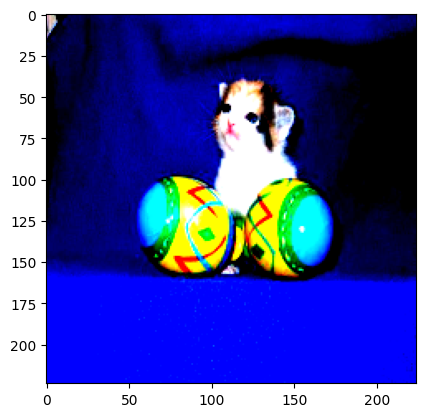

In [35]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

5. Download the pretrained VGG16 weights and then freeze the `features` module and train using the `avgpool` and `classifier` modules:

    1. First, we download the pretrained VGG16 model from the `models` class:
    2. Specify that we want to freeze all the parameters in the model downloaded previously:
    3. Replace the `avgpool` module to return a feature map of size 1 x 1 instead of 7 x 7; in other words, the output is now going to be `batch_size x 512 x 1 x 1`:
    4. Define the `classifier` module of the model, where we first flatten the output of the `avgpool` module, connect the 512 units to the 128 units, and perform an activation prior to connecting to the output layer:
    5. Define the loss function (`loss_fn`) and `optimizer`, and return them along with the defined model:

Note that, in the preceding code, we have first frozen all the parameters of the pretrained model and have then overwritten the `avgpool` and `classifier` modules. Now, the rest of the code is going to look similar to what we have seen in the previous chapter.

In [36]:
class PretrainedNet(nn.Module):
    def __init__(self, model_name='vgg16'):
        super(PretrainedNet, self).__init__()
        if model_name == 'vgg16':
            self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        if model_name == 'resnet18':
            self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1),
        )

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.model(x)
        x = self.sigmoid(x)
        return x
    
def get_model(model_name='vgg16'):
    model = PretrainedNet(model_name)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

A summary of the model is as follows:

In [37]:
from torchsummary import summary

model, criterion, optimizer = get_model()
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Note that the number of trainable parameters is only 65,793 out of a total of 14.7 million, as we have frozen the `features` module and have overwritten the `avgpool` and `classifier` modules. Now, only the `classifier` module will have weights that will be learned.

6. Define a function to fetch the data loaders:

In [39]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [40]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model(model_name='vgg16')

7. Train the model over increasing epochs, just like we did in the previous chapter: 

In [41]:
train_losses, train_accuracies, val_losses, val_accuracies = train(model, loss_fn, optimizer, trn_dl, val_dl)

Epoch 0:	Train Loss: 0.2527	Train Accuracy: 0.9667	Val Loss: 0.0537	Val Accuracy: 1.0000
Epoch 1:	Train Loss: 0.0531	Train Accuracy: 0.9849	Val Loss: 0.0329	Val Accuracy: 1.0000
Epoch 2:	Train Loss: 0.0356	Train Accuracy: 0.9909	Val Loss: 0.0242	Val Accuracy: 1.0000
Epoch 3:	Train Loss: 0.0280	Train Accuracy: 0.9919	Val Loss: 0.0744	Val Accuracy: 0.9688
Epoch 4:	Train Loss: 0.0213	Train Accuracy: 0.9970	Val Loss: 0.0370	Val Accuracy: 0.9688


8. Plot the training and test accuracy values over increasing epochs: 

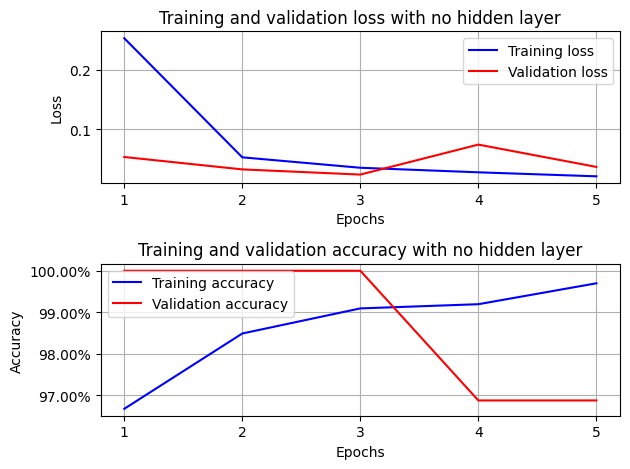

In [42]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Note that we are able to get an accuracy of 98% within the first epoch, even on a small dataset of 1,000 images (500 images of each class).

In addition to VGG16, there are the VGG11 and VGG19 pretrained architectures, which work just like VGG16 but with a different number of layers. VGG19 has more parameters than that of VGG16 as it has a higher number of layers.

## Understanding the ResNet architecture

### Implementing ResNet18

In [43]:
# trn_dl, val_dl = get_data()
# model, loss_fn, optimizer = get_model(model_name='resnet18')
# train_losses, train_accuracies, val_losses, val_accuracies = train(model, loss_fn, optimizer, trn_dl, val_dl)
# plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Besides VGG and ResNet, some of the other prominent pretrained models are InceptionNet, MobileNet, DenseNet, SqueezeNet, etc.